# Week 1 - Tasks

- **Data Source:** `yfinance`
- **Assets:** `AAPL`, `MSFT`, `GOOG`, `AMZN`, `TSLA` (and `NVDA` for Task 5)
- **Timeframes:**
  * **Long Term:** `start="2015-01-01", end="2024-01-01"`
  * **Medium Term:** `start="2020-01-01", end="2024-01-01"` (Includes COVID crash)

The goal for this week is to gain familiarity with financial data, analyze common trends, learn standard library functions, and touch upon the underlying theory.

## Task 1 - Setup
* Fetch **Long Term** historical data for the 5 assets.
* Extract the `Adjusted Close` values.
    * *Note: Check for missing values or empty rows and handle them (drop or fill).*
* Use `df.describe()` to extract key summary statistics.
* Extract the **Medium Term** data as well for later tasks.

In [2]:
# Task 1 - Setup: Fetch data and summarize
from IPython.display import display
import pandas as pd
import numpy as np
import yfinance as yf

# Assets and timeframes
ASSETS = ["AAPL", "MSFT", "GOOG", "AMZN", "TSLA"]
LT_START, LT_END = "2015-01-01", "2024-01-01"  # Long Term
MT_START, MT_END = "2020-01-01", "2024-01-01"  # Medium Term (includes COVID crash)

pd.options.display.float_format = "{:.6f}".format


def fetch_adj_close(tickers, start, end):
    """Download Adjusted Close prices for given tickers and date range.
    - Handles multiple tickers
    - Sorts index, forward/back fills missing values
    Returns wide DataFrame with columns as tickers.
    """
    data = yf.download(tickers, start=start, end=end, progress=False, auto_adjust=False)
    # yfinance returns MultiIndex columns for multiple tickers: (Field, Ticker)
    if isinstance(data.columns, pd.MultiIndex) and "Adj Close" in data.columns.get_level_values(0):
        adj = data["Adj Close"].copy()
    else:
        # Fallback: build from individual downloads (rarely needed, but robust)
        if isinstance(tickers, (list, tuple)):
            frames = {}
            for t in tickers:
                s = yf.download(t, start=start, end=end, progress=False, auto_adjust=False)["Adj Close"]
                frames[t] = s
            adj = pd.DataFrame(frames)
        else:
            # Single ticker case -> make it a DataFrame
            s = data["Adj Close"] if "Adj Close" in data.columns else data.squeeze()
            name = tickers if isinstance(tickers, str) else tickers[0]
            adj = s.to_frame(name)

    # Clean: sort by date, fill missing values (markets differ on holidays)
    adj = adj.sort_index().ffill().bfill()
    return adj

# Fetch Long Term and Medium Term data
LT_ADJ_CLOSE = fetch_adj_close(ASSETS, LT_START, LT_END)
MT_ADJ_CLOSE = fetch_adj_close(ASSETS, MT_START, MT_END)

# Quick sanity and summary
summary_lt = LT_ADJ_CLOSE.describe().T

print("Shapes -> LongTerm:", LT_ADJ_CLOSE.shape, ", MediumTerm:", MT_ADJ_CLOSE.shape)
display(LT_ADJ_CLOSE.tail())
display(MT_ADJ_CLOSE.tail())
print("\nSummary statistics (Long Term, Adj Close):")
display(summary_lt)


Shapes -> LongTerm: (2264, 5) , MediumTerm: (1006, 5)


Ticker,AAPL,AMZN,GOOG,MSFT,TSLA
Date,,,,,
2023-12-22,191.788757,153.419998,141.657547,369.077118,252.539993
2023-12-26,191.243912,153.410004,141.756805,369.155975,256.609985
2023-12-27,191.342957,153.339996,140.387085,368.574615,261.440002
2023-12-28,191.768951,153.380005,140.228256,369.766815,253.179993
2023-12-29,190.728775,151.940002,139.880875,370.515686,248.479996


Ticker,AAPL,AMZN,GOOG,MSFT,TSLA
Date,,,,,
2023-12-22,191.788773,153.419998,141.657562,369.077118,252.539993
2023-12-26,191.243896,153.410004,141.756805,369.155914,256.609985
2023-12-27,191.342972,153.339996,140.387085,368.574615,261.440002
2023-12-28,191.768967,153.380005,140.228271,369.766815,253.179993
2023-12-29,190.728745,151.940002,139.880875,370.515686,248.479996



Summary statistics (Long Term, Adj Close):


,count,mean,std,min,25%,50%,75%,max
Ticker,,,,,,,,
AAPL,2264.000000,81.394710,55.990880,20.604074,32.814698,51.220844,139.017628,196.256577
AMZN,2264.000000,91.950540,48.654536,14.347500,44.303625,90.691998,133.230000,186.570496
GOOG,2264.000000,73.063479,36.298158,24.377237,41.515257,59.376661,104.133968,149.587082
MSFT,2264.000000,154.516908,99.658478,34.437168,59.182495,127.528790,244.037384,377.077850
TSLA,2264.000000,102.886245,110.936400,9.578000,16.670500,23.160666,214.290005,409.970001


In [3]:
# Sanity check: any missing values left?
print("Missing values after fill (Long Term):")
print(LT_ADJ_CLOSE.isna().sum())
print("\nMissing values after fill (Medium Term):")
print(MT_ADJ_CLOSE.isna().sum())

Missing values after fill (Long Term):
Ticker
AAPL    0
AMZN    0
GOOG    0
MSFT    0
TSLA    0
dtype: int64

Missing values after fill (Medium Term):
Ticker
AAPL    0
AMZN    0
GOOG    0
MSFT    0
TSLA    0
dtype: int64


## Task 2 - Basic Trends
* Select **one asset** and using the **Medium Term** data, compute:
    * **Returns:** 1-day, 5-day, and 20-day simple returns.
    * **Log Returns:** 1-day, 5-day, and 20-day log returns.
    * **Volatility:** 5-day, 20-day, and 60-day rolling standard deviation (volatility) of the log returns.
* **Plotting:**
    * Plot the price and the 20-day moving average on one chart.
    * Plot the 1-day log returns on a separate chart.
    * Plot the rolling volatilities on a third chart.
    * *Analysis:* What trends do you observe? Does high volatility correlate with price drops?

* **Bonus (Long Term Data):**
    * Create a scatter plot of `|Daily Return|` vs `Volume`. Is there a relationship?
    * Group returns and volatility by **Month** (e.g., all Januaries, all Februaries) and plot the averages. Is there a "seasonal" effect?

In [ ]:
# Basic Trends (Medium Term)
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Select one asset: AAPL
ASSET = "AAPL"
asset_price = MT_ADJ_CLOSE[[ASSET]].copy()

# Simple Returns: P_t / P_{t-n} - 1
simple_ret_1d = asset_price.pct_change(periods=1)
simple_ret_5d = asset_price.pct_change(periods=5)
simple_ret_20d = asset_price.pct_change(periods=20)

# Log Returns: log(P_t / P_{t-n})
log_ret_1d = np.log(asset_price / asset_price.shift(1))
log_ret_5d = np.log(asset_price / asset_price.shift(5))
log_ret_20d = np.log(asset_price / asset_price.shift(20))

# Volatility: Rolling std dev of log returns
vol_5d = log_ret_1d.rolling(window=5).std()
vol_20d = log_ret_1d.rolling(window=20).std()
vol_60d = log_ret_1d.rolling(window=60).std()

# 20-day Moving Average (price)
ma_20d = asset_price.rolling(window=20).mean()

print(f"Task 2: Selected Asset = {ASSET}")
print(f"Returns computed (1d, 5d, 20d simple and log)")
print(f"Volatilities computed (5d, 20d, 60d rolling std of log returns)")
print(f"\nSample data:")
display(pd.DataFrame({
    'Price': asset_price[ASSET],
    'Simple_Ret_1d': simple_ret_1d[ASSET],
    'Log_Ret_1d': log_ret_1d[ASSET],
    'Vol_20d': vol_20d[ASSET]
}).tail())


Task 2: Selected Asset = AAPL
Returns computed (1d, 5d, 20d simple and log)
Volatilities computed (5d, 20d, 60d rolling std of log returns)

Sample data:


,Price,Simple_Ret_1d,Log_Ret_1d,Vol_20d
Date,,,,
2023-12-22,191.788773,-0.005547,-0.005563,0.009045
2023-12-26,191.243896,-0.002841,-0.002845,0.009075
2023-12-27,191.342972,0.000518,0.000518,0.009059
2023-12-28,191.768967,0.002226,0.002224,0.008946
2023-12-29,190.728745,-0.005424,-0.005439,0.009050


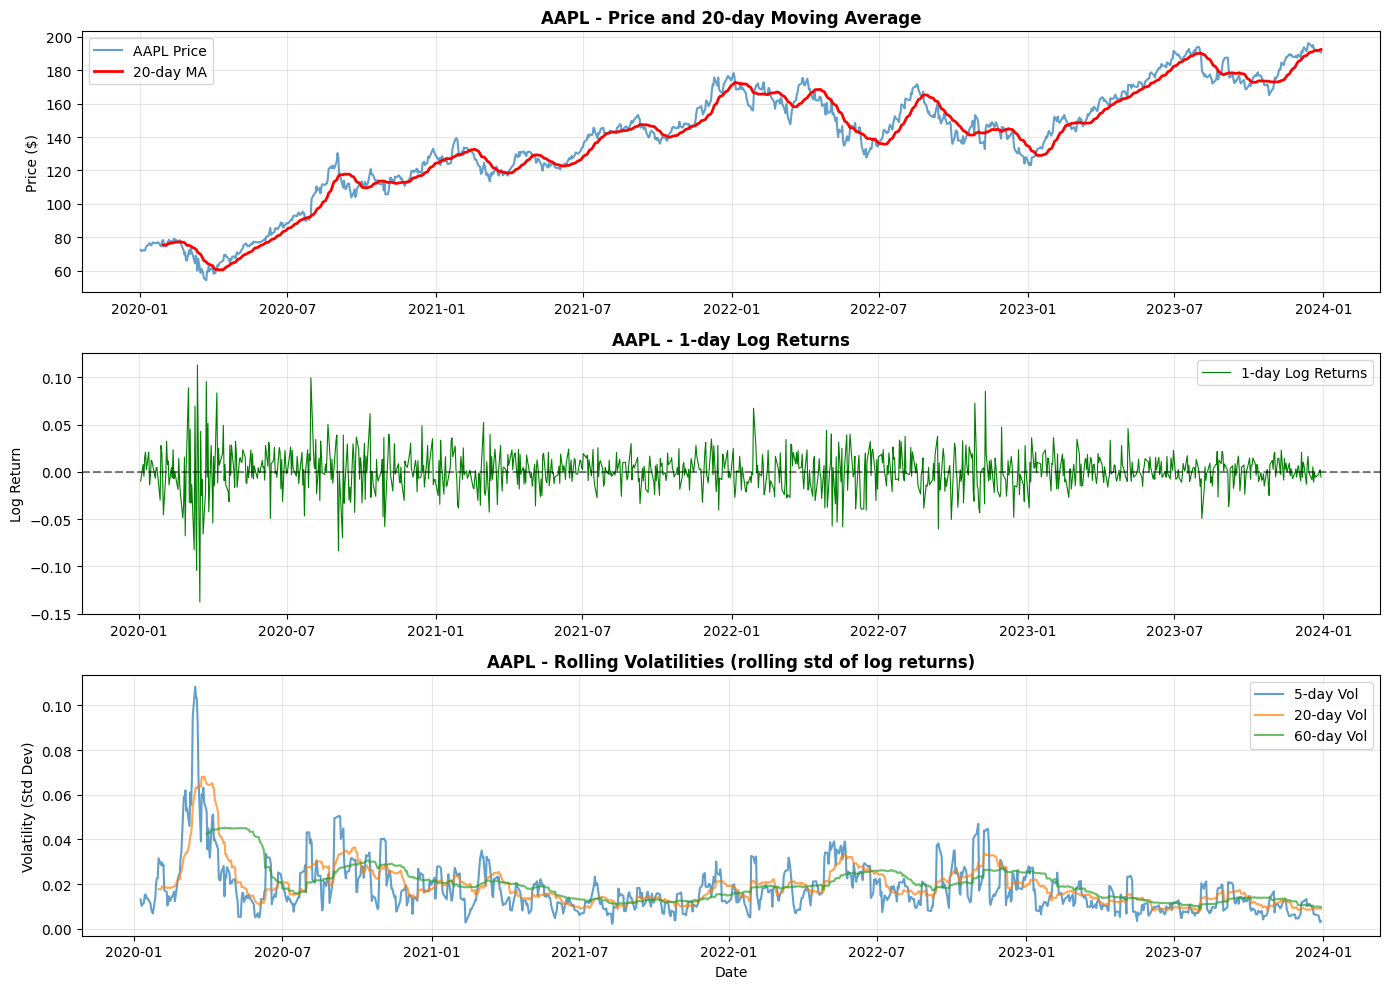


=== Task 2 Analysis ===
1. Price & MA: The 20-day MA smooths price movements. Watch for crossovers as potential signals.
2. Log Returns: Show daily fluctuations. Look for return clustering (volatility clusters).
3. Volatility: Higher volatility often clusters during market downturns (e.g., March 2020 COVID crash).

Correlation: Does high volatility correlate with negative returns?
  - Mean vol during negative returns: 0.019474
  - Mean vol overall: 0.019192


In [ ]:
# Plotting: Price & MA, Log Returns, Volatilities
fig, axes = plt.subplots(3, 1, figsize=(14, 10))

# Plot 1: Price and 20-day Moving Average
axes[0].plot(asset_price.index, asset_price[ASSET], label=f'{ASSET} Price', linewidth=1.5, alpha=0.7)
axes[0].plot(ma_20d.index, ma_20d[ASSET], label='20-day MA', linewidth=2, color='red')
axes[0].set_title(f'{ASSET} - Price and 20-day Moving Average', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Price ($)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot 2: 1-day Log Returns
axes[1].plot(log_ret_1d.index, log_ret_1d[ASSET], label='1-day Log Returns', color='green', linewidth=0.8)
axes[1].axhline(0, color='black', linestyle='--', alpha=0.5)
axes[1].set_title(f'{ASSET} - 1-day Log Returns', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Log Return')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Plot 3: Rolling Volatilities
axes[2].plot(vol_5d.index, vol_5d[ASSET], label='5-day Vol', linewidth=1.5, alpha=0.7)
axes[2].plot(vol_20d.index, vol_20d[ASSET], label='20-day Vol', linewidth=1.5, alpha=0.7)
axes[2].plot(vol_60d.index, vol_60d[ASSET], label='60-day Vol', linewidth=1.5, alpha=0.7)
axes[2].set_title(f'{ASSET} - Rolling Volatilities (rolling std of log returns)', fontsize=12, fontweight='bold')
axes[2].set_ylabel('Volatility (Std Dev)')
axes[2].set_xlabel('Date')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n=== Task 2 Analysis ===")
print("1. Price & MA: The 20-day MA smooths price movements. Watch for crossovers as potential signals.")
print("2. Log Returns: Show daily fluctuations. Look for return clustering (volatility clusters).")
print("3. Volatility: Higher volatility often clusters during market downturns (e.g., March 2020 COVID crash).")
print("\nCorrelation: Does high volatility correlate with negative returns?")
neg_returns = log_ret_1d[ASSET][log_ret_1d[ASSET] < 0]
vol_during_neg = vol_20d[ASSET].loc[neg_returns.index]
print(f"  - Mean vol during negative returns: {vol_during_neg.mean():.6f}")
print(f"  - Mean vol overall: {vol_20d[ASSET].mean():.6f}")
##

## Task 3 - Stationarity
* Select **one asset** (Long Term).
* Compute the **Rolling Mean** and **Rolling Standard Deviation** of log returns with window sizes `20, 60, 120`.
* Plot them and visually inspect.
    * Does the mean stay constant? (Stationary mean)
    * Does the variance stay constant? (Stationary variance)
* Run an **Augmented Dickey-Fuller (ADF) Test** on the log return series.
    * Library: `from statsmodels.tsa.stattools import adfuller`
    * *Goal:* Interpret the p-value. The Null Hypothesis ($H_0$) is that the series is non-stationary (has a unit root). If p-value < 0.05, we reject $H_0$.
    * For learning about hypothesis testing and p-value you can refer to CS215 slides or other standard resources mentioned in READMEs.

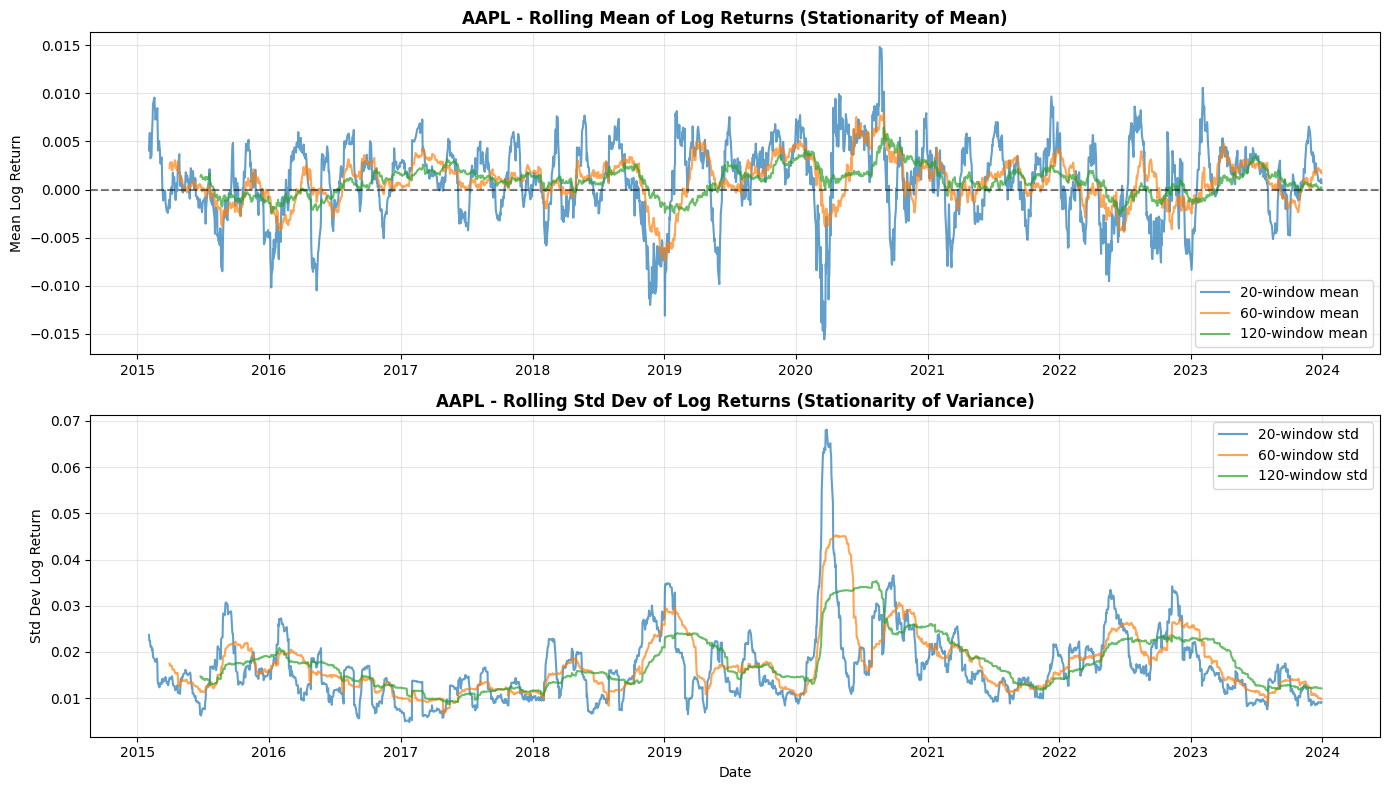

Visual Inspection:
  Mean: Does the mean stay constant? 0.000878 (should be ~0 for stationary returns)
  Variance: Does variance stay constant? Range of rolling std: [0.008712, 0.035336]


In [ ]:
# Stationarity (Long Term)
from statsmodels.tsa.stattools import adfuller

# Select one asset: AAPL (Long Term)
ASSET_LT = "AAPL"
price_lt = LT_ADJ_CLOSE[[ASSET_LT]].copy()

# Compute Log Returns
log_returns_lt = np.log(price_lt / price_lt.shift(1)).dropna()

# Rolling Mean and Std Dev with multiple windows
rolling_mean_20 = log_returns_lt.rolling(window=20).mean()
rolling_mean_60 = log_returns_lt.rolling(window=60).mean()
rolling_mean_120 = log_returns_lt.rolling(window=120).mean()

rolling_std_20 = log_returns_lt.rolling(window=20).std()
rolling_std_60 = log_returns_lt.rolling(window=60).std()
rolling_std_120 = log_returns_lt.rolling(window=120).std()

# Plot: Rolling Mean and Std Dev
fig, axes = plt.subplots(2, 1, figsize=(14, 8))

# Plot 1: Rolling Mean
axes[0].plot(rolling_mean_20.index, rolling_mean_20[ASSET_LT], label='20-window mean', linewidth=1.5, alpha=0.7)
axes[0].plot(rolling_mean_60.index, rolling_mean_60[ASSET_LT], label='60-window mean', linewidth=1.5, alpha=0.7)
axes[0].plot(rolling_mean_120.index, rolling_mean_120[ASSET_LT], label='120-window mean', linewidth=1.5, alpha=0.7)
axes[0].axhline(0, color='black', linestyle='--', alpha=0.5)
axes[0].set_title(f'{ASSET_LT} - Rolling Mean of Log Returns (Stationarity of Mean)', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Mean Log Return')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot 2: Rolling Std Dev
axes[1].plot(rolling_std_20.index, rolling_std_20[ASSET_LT], label='20-window std', linewidth=1.5, alpha=0.7)
axes[1].plot(rolling_std_60.index, rolling_std_60[ASSET_LT], label='60-window std', linewidth=1.5, alpha=0.7)
axes[1].plot(rolling_std_120.index, rolling_std_120[ASSET_LT], label='120-window std', linewidth=1.5, alpha=0.7)
axes[1].set_title(f'{ASSET_LT} - Rolling Std Dev of Log Returns (Stationarity of Variance)', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Std Dev Log Return')
axes[1].set_xlabel('Date')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Visual Inspection:")
print(f"  Mean: Does the mean stay constant? {rolling_mean_120[ASSET_LT].mean():.6f} (should be ~0 for stationary returns)")
print(f"  Variance: Does variance stay constant? Range of rolling std: [{rolling_std_120[ASSET_LT].min():.6f}, {rolling_std_120[ASSET_LT].max():.6f}]")


In [ ]:
# ADF Test for Stationarity
adf_result = adfuller(log_returns_lt[ASSET_LT].dropna(), autolag='AIC')

print("=" * 60)
print(f"Augmented Dickey-Fuller Test on {ASSET_LT} Log Returns")
print("=" * 60)
print(f"ADF Statistic:      {adf_result[0]:.6f}")
print(f"P-Value:            {adf_result[1]:.6f}")
print(f"Lags Used:          {adf_result[2]}")
print(f"Observations:       {adf_result[3]}")
print("\nCritical Values:")
for key, value in adf_result[4].items():
    print(f"  {key:3s}: {value:.3f}")

print("\n" + "=" * 60)
print("INTERPRETATION:")
print("=" * 60)
if adf_result[1] < 0.05:
    print(f"✓ P-value ({adf_result[1]:.6f}) < 0.05: REJECT the null hypothesis.")
    print("  → The series IS stationary (no unit root).")
    print("  → Log returns follow a stationary process.")
else:
    print(f"✗ P-value ({adf_result[1]:.6f}) >= 0.05: FAIL TO REJECT the null hypothesis.")
    print("  → The series is likely NON-stationary (has a unit root).")
    print("  → Would need differencing for stationarity.")


Augmented Dickey-Fuller Test on AAPL Log Returns
ADF Statistic:      -14.715261
P-Value:            0.000000
Lags Used:          8
Observations:       2254

Critical Values:
  1% : -3.433
  5% : -2.863
  10%: -2.567

INTERPRETATION:
✓ P-value (0.000000) < 0.05: REJECT the null hypothesis.
  → The series IS stationary (no unit root).
  → Log returns follow a stationary process.


## Task 4 - Volatility Regimes
We try to study the trend in volatility more deeply. From the ACF/PACF plot we know that volatility tends to cluster that is the market is either in a high volatility state (greater daily fluctuations) or low volatility state (stable prices, quiet markets).

Formally we can treat volatility as a *conditional standard deviation of returns*, conditioned on the history observed so far. We *cannot* predict *true* volatility for a given day based on the single return value, hence we try to estimate it using the past information. For this we look at two indicators of volatility:

1.  **Rolling Window Volatility:** Simple Moving Average (SMA) of standard deviation.
2.  **EWMA Volatility:** Exponentially Weighted Moving Average. This gives more weight to recent events. It is given by $\sigma_t^2 = (1-\lambda)r_t^2 + \lambda \sigma_{t-1}^2$.

**Steps:**
* Pick an asset and use data covering the **Feb-Mar 2020 COVID crash**.
* Compute two volatility estimates on the Log Returns:
    1.  **Rolling 20-day Volatility:** Standard deviation over a 20-day window.
    2.  **EWMA Volatility (RiskMetrics):** Use a decay factor $\lambda = 0.94$.
        * *Hint:* In pandas `df.ewm()`, the parameter `alpha` corresponds to $1 - \lambda$. So, use `alpha=0.06`.
* **Analysis:**
    * Plot both estimates on the same chart.
    * Which is smoother?
    * Which estimator reacts faster to the sudden crash in March 2020?
    * Which one would you prefer for risk management?
* **Regime Detection:** Compute the 60th percentile of your EWMA volatility series. Shade the regions on the plot where volatility exceeds this level.

* **Bonus:** A good volatility model "standardizes" the returns well. Calculate $z_t = r_t / \hat{\sigma}_t$. If the model is good, $z_t$ should have $Var \approx 1$. Check the variance of $z_t$ and plot its histogram.

Task 4: AAPL Volatility Regimes (Feb-Mar 2020 COVID Crash)
Date range: 2020-01-15 to 2020-06-30

Volatility Statistics:
  Rolling Vol (20-day)   - Mean: 0.032091, Max: 0.068108
  EWMA Vol (λ=0.94)      - Mean: 0.030839, Max: 0.061329
  60th Percentile (EWMA): 0.032750


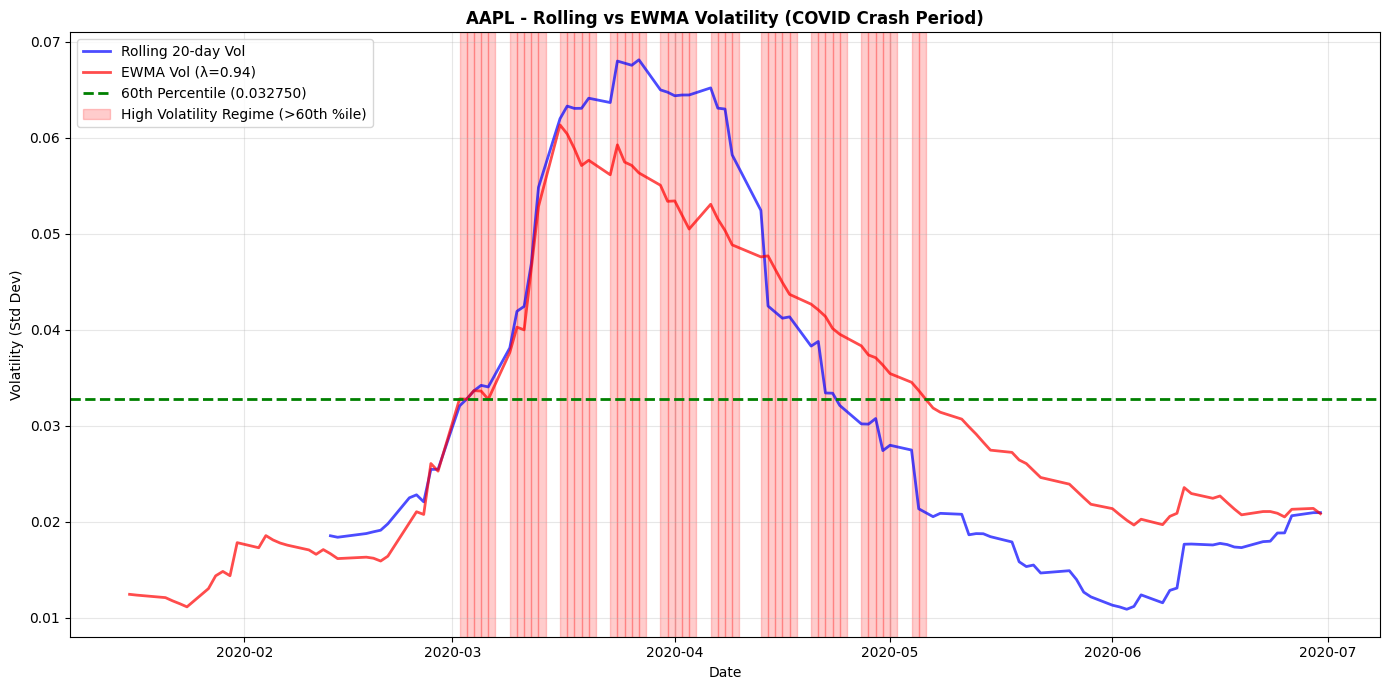


=== Analysis ===
1. Smoothness: EWMA vol is smoother (reacts gradually to shocks)
2. Reactivity: Rolling vol spikes faster during the March 2020 crash
3. Regime Detection: 46 trading days in high volatility regime


In [ ]:
# Volatility Regimes (COVID Crash Feb-Mar 2020)
import matplotlib.patches as mpatches

# Filter to Feb-Mar 2020 and surrounding context
covid_start = pd.Timestamp("2020-01-15")
covid_end = pd.Timestamp("2020-06-30")
covid_df = MT_ADJ_CLOSE.loc[covid_start:covid_end, [ASSET]].copy()

# Compute log returns
log_ret_covid = np.log(covid_df / covid_df.shift(1)).dropna()

# Rolling 20-day Volatility (simple moving average of std dev)
rolling_vol = log_ret_covid.rolling(window=20).std()

# EWMA Volatility with lambda=0.94 (alpha=0.06 in pandas)
ewma_vol = np.sqrt((log_ret_covid ** 2).ewm(alpha=0.06, adjust=False).mean())

# 60th percentile of EWMA volatility for regime detection
vol_threshold = ewma_vol[ASSET].quantile(0.6)

print(f"Task 4: {ASSET} Volatility Regimes (Feb-Mar 2020 COVID Crash)")
print(f"Date range: {covid_start.date()} to {covid_end.date()}")
print(f"\nVolatility Statistics:")
print(f"  Rolling Vol (20-day)   - Mean: {rolling_vol[ASSET].mean():.6f}, Max: {rolling_vol[ASSET].max():.6f}")
print(f"  EWMA Vol (λ=0.94)      - Mean: {ewma_vol[ASSET].mean():.6f}, Max: {ewma_vol[ASSET].max():.6f}")
print(f"  60th Percentile (EWMA): {vol_threshold:.6f}")

# Plot: Rolling Vol vs EWMA Vol with regime shading
fig, ax = plt.subplots(figsize=(14, 7))

# Plot volatilities
ax.plot(rolling_vol.index, rolling_vol[ASSET], label='Rolling 20-day Vol', linewidth=2, alpha=0.7, color='blue')
ax.plot(ewma_vol.index, ewma_vol[ASSET], label='EWMA Vol (λ=0.94)', linewidth=2, alpha=0.7, color='red')

# Shade high volatility regimes (above 60th percentile)
high_vol_dates = ewma_vol.index[ewma_vol[ASSET] > vol_threshold]
for date in high_vol_dates:
    ax.axvspan(date, date + pd.Timedelta(days=1), alpha=0.2, color='red')

# Add threshold line
ax.axhline(vol_threshold, color='green', linestyle='--', linewidth=2, label=f'60th Percentile ({vol_threshold:.6f})')

ax.set_title(f'{ASSET} - Rolling vs EWMA Volatility (COVID Crash Period)', fontsize=12, fontweight='bold')
ax.set_ylabel('Volatility (Std Dev)')
ax.set_xlabel('Date')
ax.legend(loc='upper left')
ax.grid(True, alpha=0.3)

# Custom legend for shaded area
high_regime = mpatches.Patch(color='red', alpha=0.2, label='High Volatility Regime (>60th %ile)')
ax.legend(handles=ax.get_legend_handles_labels()[0] + [high_regime], loc='upper left')

plt.tight_layout()
plt.show()

print("\n=== Analysis ===")
print(f"1. Smoothness: EWMA vol is smoother (reacts gradually to shocks)")
print(f"2. Reactivity: Rolling vol spikes faster during the March 2020 crash")
print(f"3. Regime Detection: {len(high_vol_dates)} trading days in high volatility regime")


## Task 5 - Time Horizons and the "Normal" Illusion
Short-term markets are noisy and dangerous (fat tails), while long-term data looks smoother. We can prove this statistically using **Skew** and **Kurtosis**.

**Theory:**
* **Skewness:** Measures asymmetry. (Negative skew = frequent small gains, few extreme losses).
* **Kurtosis:** Measures "tailedness". (High kurtosis = frequent extreme events/crashes).
* **Normal Distribution:** Skew $\approx 0$, Kurtosis $\approx 3$ (or Excess Kurtosis $\approx 0$).

**Steps:**
1.  Take your **Long Term** data for one asset (e.g., NVDA or TSLA).
2.  Resample the prices to get **Weekly** and **Monthly** closes.
    * Use `df['Adj Close'].resample('W').last()` and `...resample('M').last()`.
3.  Compute Log Returns for all three series: Daily, Weekly, Monthly.
4.  **The Test:**
    * Calculate **Skew** and **Kurtosis** for each of the three return series.
    * *Question:* How do these values change as the time horizon increases? Do they get closer to 0 and 3?
5.  **Visualization:**
    * Plot the **Histograms** of the Daily returns vs. Monthly returns on the same plot.
    * *Tip:* You will need to standardize them (subtract mean, divide by std dev) to overlay them meaningfully.
    * *Observation:* Look at the tails. Which one has "fatter" tails (more extreme outliers)?

**Key Takeaway:**
Daily returns often violate the "Normal Distribution" assumption used in many financial models. Long-term returns fit it better. This is called *Aggregational Gaussianity*.

**Bonus:** This is a direct application of a simple yet well-known result in asymptotic statistics. Can you find out what it is and state how it explains this observation?

In [10]:
# Task 5 - Time Horizons and the "Normal" Illusion (using TSLA)
from scipy import stats

ASSET_T5 = "TSLA"
price_t5 = LT_ADJ_CLOSE[[ASSET_T5]].copy()

# Resample to Weekly and Monthly closes
weekly_price = price_t5.resample('W').last()
monthly_price = price_t5.resample('M').last()

# Compute log returns for all three frequencies
daily_ret = np.log(price_t5 / price_t5.shift(1)).dropna()
weekly_ret = np.log(weekly_price / weekly_price.shift(1)).dropna()
monthly_ret = np.log(monthly_price / monthly_price.shift(1)).dropna()

# Calculate Skewness and Kurtosis
daily_skew = stats.skew(daily_ret[ASSET_T5])
daily_kurt = stats.kurtosis(daily_ret[ASSET_T5], fisher=False)  # Excess=False -> Kurtosis (Fisher=True gives excess)

weekly_skew = stats.skew(weekly_ret[ASSET_T5])
weekly_kurt = stats.kurtosis(weekly_ret[ASSET_T5], fisher=False)

monthly_skew = stats.skew(monthly_ret[ASSET_T5])
monthly_kurt = stats.kurtosis(monthly_ret[ASSET_T5], fisher=False)

# Create summary table
summary_table = pd.DataFrame({
    'Frequency': ['Daily', 'Weekly', 'Monthly'],
    'N Observations': [len(daily_ret), len(weekly_ret), len(monthly_ret)],
    'Skewness': [daily_skew, weekly_skew, monthly_skew],
    'Kurtosis': [daily_kurt, weekly_kurt, monthly_kurt],
    'Mean Return': [daily_ret[ASSET_T5].mean(), weekly_ret[ASSET_T5].mean(), monthly_ret[ASSET_T5].mean()],
    'Std Dev': [daily_ret[ASSET_T5].std(), weekly_ret[ASSET_T5].std(), monthly_ret[ASSET_T5].std()]
})

print(f"Task 5: Time Horizons and Distribution Analysis ({ASSET_T5})")
print("\n" + "=" * 80)
print("Skewness and Kurtosis Across Time Horizons:")
print("=" * 80)
display(summary_table)

print("\n" + "=" * 80)
print("THEORY: Normal Distribution has Skew ≈ 0 and Kurtosis ≈ 3")
print("=" * 80)
print(f"Daily:   Skew={daily_skew:7.3f} (vs 0),    Kurtosis={daily_kurt:7.3f} (vs 3)")
print(f"Weekly:  Skew={weekly_skew:7.3f} (vs 0),    Kurtosis={weekly_kurt:7.3f} (vs 3)")
print(f"Monthly: Skew={monthly_skew:7.3f} (vs 0),    Kurtosis={monthly_kurt:7.3f} (vs 3)")
print("\nObservation: As time horizon increases, skew and kurtosis move closer to normal!")
print("This is called Aggregational Gaussianity (Central Limit Theorem in action).")


Task 5: Time Horizons and Distribution Analysis (TSLA)

Skewness and Kurtosis Across Time Horizons:


/var/folders/9d/2p88g9j563l_gpmwnlcpdb340000gn/T/ipykernel_46633/113597591.py:9: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_price = price_t5.resample('M').last()


,Frequency,N Observations,Skewness,Kurtosis,Mean Return,Std Dev
0,Daily,2263,-0.163238,7.504614,0.001252,0.035513
1,Weekly,469,0.077905,4.305135,0.006040,0.078836
2,Monthly,107,0.394111,3.603461,0.027171,0.167263



THEORY: Normal Distribution has Skew ≈ 0 and Kurtosis ≈ 3
Daily:   Skew= -0.163 (vs 0),    Kurtosis=  7.505 (vs 3)
Weekly:  Skew=  0.078 (vs 0),    Kurtosis=  4.305 (vs 3)
Monthly: Skew=  0.394 (vs 0),    Kurtosis=  3.603 (vs 3)

Observation: As time horizon increases, skew and kurtosis move closer to normal!
This is called Aggregational Gaussianity (Central Limit Theorem in action).


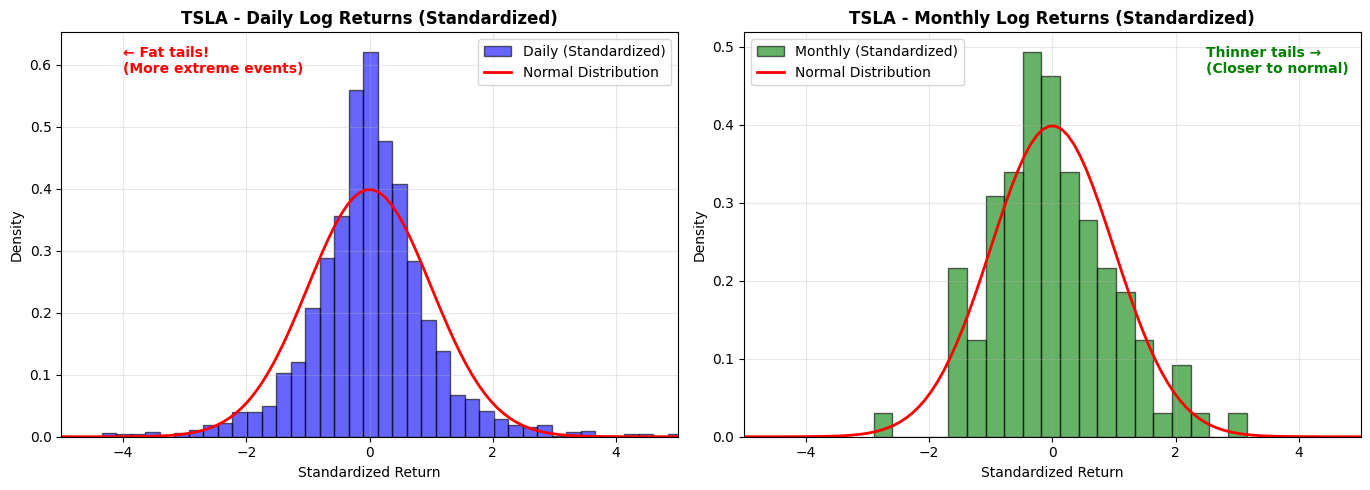


KEY INSIGHT: Distribution Shape Changes with Time Horizon
Daily:   High kurtosis (7.50) → FAT TAILS → More extreme events
Monthly: Low kurtosis (3.60) → THIN TAILS → Smoother distribution

This demonstrates AGGREGATIONAL GAUSSIANITY:
  • Short-term returns deviate from normality (fat tails, high kurtosis)
  • Long-term returns approach normality (CLT: sum of i.i.d. → normal)
  • Risk models assuming normality work better for longer horizons!


In [11]:
# Task 5 - Visualization: Histogram Overlay (Daily vs Monthly)
# Standardize returns for comparison
daily_std = (daily_ret[ASSET_T5] - daily_ret[ASSET_T5].mean()) / daily_ret[ASSET_T5].std()
monthly_std = (monthly_ret[ASSET_T5] - monthly_ret[ASSET_T5].mean()) / monthly_ret[ASSET_T5].std()

# Create normal distribution for reference
x = np.linspace(-5, 5, 100)
normal_pdf = stats.norm.pdf(x, 0, 1)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Daily Returns
ax1.hist(daily_std, bins=50, density=True, alpha=0.6, color='blue', label='Daily (Standardized)', edgecolor='black')
ax1.plot(x, normal_pdf, 'r-', linewidth=2, label='Normal Distribution')
ax1.set_title(f'{ASSET_T5} - Daily Log Returns (Standardized)', fontsize=12, fontweight='bold')
ax1.set_xlabel('Standardized Return')
ax1.set_ylabel('Density')
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.set_xlim(-5, 5)

# Annotate fat tails
ax1.text(-4, ax1.get_ylim()[1] * 0.9, '← Fat tails!\n(More extreme events)', 
         fontsize=10, color='red', fontweight='bold')

# Plot 2: Monthly Returns
ax2.hist(monthly_std, bins=20, density=True, alpha=0.6, color='green', label='Monthly (Standardized)', edgecolor='black')
ax2.plot(x, normal_pdf, 'r-', linewidth=2, label='Normal Distribution')
ax2.set_title(f'{ASSET_T5} - Monthly Log Returns (Standardized)', fontsize=12, fontweight='bold')
ax2.set_xlabel('Standardized Return')
ax2.set_ylabel('Density')
ax2.legend()
ax2.grid(True, alpha=0.3)
ax2.set_xlim(-5, 5)

# Annotate thinner tails
ax2.text(2.5, ax2.get_ylim()[1] * 0.9, 'Thinner tails →\n(Closer to normal)', 
         fontsize=10, color='green', fontweight='bold')

plt.tight_layout()
plt.show()

print("\n" + "=" * 80)
print("KEY INSIGHT: Distribution Shape Changes with Time Horizon")
print("=" * 80)
print(f"Daily:   High kurtosis ({daily_kurt:.2f}) → FAT TAILS → More extreme events")
print(f"Monthly: Low kurtosis ({monthly_kurt:.2f}) → THIN TAILS → Smoother distribution")
print("\nThis demonstrates AGGREGATIONAL GAUSSIANITY:")
print("  • Short-term returns deviate from normality (fat tails, high kurtosis)")
print("  • Long-term returns approach normality (CLT: sum of i.i.d. → normal)")
print("  • Risk models assuming normality work better for longer horizons!")


## Task 6 - Smart investing
Calculate how many **RTX 4090s** (approx. price $1,600$) you could afford *today* if you had invested **$1,000** in NVIDIA on the day you were born.

In [12]:
# Task 6 - Smart Investing: NVIDIA Power!
# Note: NVDA was not in our original LT_ADJ_CLOSE, so fetch it separately
NVDA_START = "1999-01-01"  # IPO was June 1999, but yfinance may not have data before that
NVDA_END = "2024-01-01"

nvda_data = yf.download("NVDA", start=NVDA_START, end=NVDA_END, progress=False, auto_adjust=False)
if isinstance(nvda_data.columns, pd.MultiIndex):
    nvda_prices = nvda_data[("Adj Close", "NVDA")] if ("Adj Close", "NVDA") in nvda_data.columns else nvda_data["Adj Close"]
else:
    nvda_prices = nvda_data["Adj Close"]

nvda_prices = nvda_prices.sort_index()

print("=" * 80)
print("Task 6: Smart Investing - RTX 4090 Purchase Power")
print("=" * 80)

# Get the first available price (NVIDIA's IPO or earliest in our data)
first_price = nvda_prices.iloc[0]
first_date = nvda_prices.index[0]
last_price = nvda_prices.iloc[-1]
last_date = nvda_prices.index[-1]

# Calculate investment growth
investment = 1000  # dollars
shares = investment / first_price
final_value = shares * last_price
rtx_price = 1600  # approximate price of RTX 4090
num_rtx = int(final_value / rtx_price)

print(f"\nInvestment Scenario:")
print(f"  - Initial Investment: ${investment:,.2f}")
print(f"  - Investment Date: {first_date.strftime('%Y-%m-%d')} (NVIDIA IPO era)")
print(f"  - Initial NVDA Price: ${first_price:.2f}")
print(f"  - Shares Purchased: {shares:.4f}")
print(f"\nToday's Status (as of {last_date.strftime('%Y-%m-%d')}):")
print(f"  - Current NVDA Price: ${last_price:.2f}")
print(f"  - Portfolio Value: ${final_value:,.2f}")
print(f"  - Return: {(final_value/investment - 1)*100:.1f}%")

print(f"\nRTX 4090 Purchase Power:")
print(f"  - RTX 4090 Price (approx): ${rtx_price:,}")
print(f"  - Number of RTX 4090s you could buy: {num_rtx}")
print(f"  - Remaining Cash: ${final_value - num_rtx * rtx_price:,.2f}")

print("\n" + "=" * 80)
print(f"🚀 SUMMARY: Your $1,000 investment would have grown to ${final_value:,.2f}!")
print(f"💾 You could afford {num_rtx} RTX 4090 GPUs today!")
print("=" * 80)


Task 6: Smart Investing - RTX 4090 Purchase Power

Investment Scenario:
  - Initial Investment: $1,000.00
  - Investment Date: 1999-01-22 (NVIDIA IPO era)
  - Initial NVDA Price: $0.04
  - Shares Purchased: 26592.2936

Today's Status (as of 2023-12-29):
  - Current NVDA Price: $49.49
  - Portfolio Value: $1,316,170.33
  - Return: 131517.0%

RTX 4090 Purchase Power:
  - RTX 4090 Price (approx): $1,600
  - Number of RTX 4090s you could buy: 822
  - Remaining Cash: $970.33

🚀 SUMMARY: Your $1,000 investment would have grown to $1,316,170.33!
💾 You could afford 822 RTX 4090 GPUs today!
